In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from torch import Tensor
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


## Pre-processing Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')

In [ ]:
dcs_tree_clf = DecisionTreeClassifier(random_state=0)
dcs_tree_clf.fit(df.drop(columns=['depvar']), df['depvar'])
dcs_tree_clf.score(df.drop(columns=['depvar']), df['depvar'])

feature_imp = dcs_tree_clf.feature_importances_

for_del_idx = [i if (_<0.015) else None for i, _ in enumerate(feature_imp)]

extract_del_idx = list()
for i in for_del_idx:
  if i is not None:
    extract_del_idx.append(i)

col_list = list(df.columns)

extract_del_idx.reverse()

proc_col = list()
for i in extract_del_idx:
  del col_list[i]
  
proc_col = col_list

df2 = df[proc_col]

In [ ]:
X = df2.drop('depvar', axis=1)
y = df2['depvar']

# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
df2.nunique()

int_rate                256
annual_inc             8905
dti                    4148
inq_last_6mths            7
revol_bal             36002
total_acc               107
tot_cur_bal           80613
funded_amnt            1355
funded_amnt_inv        1391
total_rec_late_fee     2752
open_acc                 62
installment           25708
revol_util             1101
total_rec_int         85095
fico_range_low           38
fico_range_high          38
depvar                    2
dtype: int64

In [ ]:
X_valid

,int_rate,annual_inc,dti,inq_last_6mths,revol_bal,total_acc,tot_cur_bal,funded_amnt,funded_amnt_inv,total_rec_late_fee,open_acc,installment,revol_util,total_rec_int,fico_range_low,fico_range_high
7750,0.1997,115000.0,23.70,1,39419,22,422474,35000,35000.0,0.00,14,926.71,0.864,16888.42,690,694
27044,0.1199,60000.0,7.18,0,11201,23,40279,10300,10250.0,34.20,8,342.06,0.862,1886.93,670,674
9143,0.1659,115000.0,22.58,0,15360,23,213426,28000,28000.0,0.00,8,689.72,0.784,7982.17,725,729
31111,0.1899,55000.0,16.84,0,4248,37,91155,10000,10000.0,36.66,19,366.51,0.802,3340.67,675,679
61217,0.1274,47000.0,24.95,0,3470,8,4264,6000,6000.0,0.00,4,201.42,0.770,1242.33,695,699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8024,0.1655,42000.0,39.74,3,9621,26,114190,2500,2500.0,0.00,15,88.58,0.454,675.70,660,664
4532,0.1349,53000.0,9.69,1,5743,31,75381,6500,6500.0,0.00,9,220.55,0.463,1436.87,670,674
43959,0.1629,45000.0,26.24,0,19590,18,33929,20125,20125.0,0.00,9,492.51,0.574,8008.41,700,704
11681,0.2170,60000.0,28.56,3,7849,23,76700,20000,20000.0,0.00,10,548.98,0.313,5343.40,705,709


In [ ]:
# 정규화 // 오히려 정규화하고 점수 더 안좋아지는 경향

X_train_sc = StandardScaler().fit_transform(X_train)
X_valid_sc = StandardScaler().fit_transform(X_valid)

In [ ]:
X_train_sc[1]

array([ 0.77342546, -0.14359956, -1.86343222, -0.70224271, -0.60072206,
       -0.81600913, -0.84822687, -0.78431116, -0.7838916 , -0.16409968,
       -1.02798046, -0.68712803, -0.95763191, -0.20942225, -1.10215179,
       -1.10213194])

In [ ]:
y_train.head()

41107    0
83021    0
6558     0
97211    1
57297    0
Name: depvar, dtype: int64

In [ ]:
# Data 증축 전, 결과 값 비율
print("Before OverSampling, counts of label '0': {}".format(sum(y_train==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))

Before OverSampling, counts of label '0': 53987
Before OverSampling, counts of label '1': 26013


In [4]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# 16개 칼럼추출
rnd_clf = RandomForestClassifier(random_state=42)
lgbm_clf = LGBMClassifier(random_state=42)
xgb_clf = xgboost.XGBClassifier(max_depth = 11, n_estimators = 100, eval_metric='mlogloss', random_state=42) # 최적값 구한것

stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)
# y_pred_stack = stacking_clf.predict(X_valid)

StackingClassifier(estimators=[('rnd', RandomForestClassifier(random_state=42)),
                               ('lgbm', LGBMClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(eval_metric='mlogloss',
                                              max_depth=11, random_state=42))],
                   final_estimator=LGBMClassifier())

In [ ]:
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.35)  # 0.6447 -> 0.6375
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.4)   # 0.6343 -> 0.6266
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.3)   # 0.6404 ->0.6410


정확도: 0.7166
정밀도: 0.5490
재현율: 0.7698
AUC: 0.7301
F1: 0.6410


In [ ]:
# 16개 칼럼 추출 + 정규화
rnd_clf = RandomForestClassifier(random_state=42)
lgbm_clf = LGBMClassifier(random_state=42)
xgb_clf = xgboost.XGBClassifier(max_depth = 11, n_estimators = 100, eval_metric='mlogloss', random_state=42) # 최적값 구한것

stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train_sc, y_train)

StackingClassifier(estimators=[('rnd', RandomForestClassifier(random_state=42)),
                               ('lgbm', LGBMClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(eval_metric='mlogloss',
                                              max_depth=11, random_state=42))],
                   final_estimator=LGBMClassifier())

In [ ]:
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid_sc)[:,1]>0.3)  # 0.6346


정확도: 0.7103
정밀도: 0.5420
재현율: 0.7654
AUC: 0.7244
F1: 0.6346


## Data 편향 제거 처리

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=27) 
X_train_smt, y_train_smt = sm.fit_resample(X_train, y_train)

In [ ]:
print("After OverSampling, counts of label '0': {}".format(sum(y_train_smt==0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_smt==1)))

After OverSampling, counts of label '0': 54004
After OverSampling, counts of label '1': 54004


In [ ]:
rnd_clf = RandomForestClassifier()
lgbm_clf = LGBMClassifier()
xgb_clf = xgboost.XGBClassifier(max_depth = 11, n_estimators = 100, eval_metric='mlogloss') # 최적값 구한것

stacking_clf_smt = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf_smt.fit(X_train_smt, y_train_smt)

StackingClassifier(estimators=[('rnd', RandomForestClassifier()),
                               ('lgbm', LGBMClassifier()),
                               ('xgb',
                                XGBClassifier(eval_metric='mlogloss',
                                              max_depth=11))],
                   final_estimator=LGBMClassifier())

In [ ]:
# SMOTE - 오히려 더 감소하는 경향
# get_clf_eval(y_valid, stacking_clf_smt.predict_proba(X_valid)[:,1]>0.4) #0.6166
# get_clf_eval(y_valid, stacking_clf_smt.predict_proba(X_valid)[:,1]>0.35)  #0.6288
get_clf_eval(y_valid, stacking_clf_smt.predict_proba(X_valid)[:,1]>0.3)  #0.6299


정확도: 0.7006
정밀도: 0.5304
재현율: 0.7753
AUC: 0.7197
F1: 0.6299


## 하이퍼 파라미터 최적화

In [ ]:
# rnd_clf = RandomForestClassifier()
# xgb_clf = XGBClassifier()
# lgbm_clf = LGBMClassifier()
# rid_clf = RidgeClassifier()
# dtc_clf = DecisionTreeClassifier()
# svm_clf = SVC()
# ada_clf = AdaBoostClassifier()
# gbc_clf = GradientBoostingClassifier()
# bag_clf = BaggingClassifier()
# ext_clf = ExtraTreesClassifier()
# knn_clf = KNeighborsClassifier()
# svc_clf = SVC()

In [ ]:
# 1. Random Forest  (1차 12, 8, 8, 150)
rnd_clf = RandomForestClassifier(random_state=42)

param_grid = { 'n_estimators' : [50, 100, 150],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=rnd_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv) 

results_rnd=grid_search.fit(X_train, y_train)

results_rnd.best_params_

{'max_depth': 12,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'n_estimators': 150}

In [ ]:
# 2. XGBoost
xgb_clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
# GPU사용시ㅡ tree_method='gpu_hist' 
# Do not use this for test/validation tasks as some information may be lost in quantisation. 
# This DMatrix is primarily designed to save memory in training from device memory inputs by avoiding intermediate storage. 

param_grid = {'max_depth':[7],
              'n_estimators':[200],
              }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='accuracy', 
                           error_score=0) 

results_xgb=grid_search.fit(X_train, y_train)

results_xgb.best_params_

{'max_depth': 7, 'n_estimators': 200}

In [ ]:
# 3. Light GBM
lgbm_clf = LGBMClassifier()

param_grid = {'max_depth':[11],
              'n_estimators':[150]
              }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=lgbm_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='accuracy', 
                           error_score=0) 

results=grid_search.fit(X_train, y_train)

results.best_params_

{'max_depth': 11, 'n_estimators': 150}

In [ ]:
# 4. ExtraTree 
ext_clf = ExtraTreesClassifier()

param_grid = {'max_depth':[11],
              'n_estimators':[150]
              }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=lgbm_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='accuracy', 
                           error_score=0) 

results=grid_search.fit(X_train, y_train)

results.best_params_

In [ ]:
def cut_outlier(df2, columns):
    df=df2.copy()
    for column in columns:
        q1=df[column].quantile(.25)
        q3=df[column].quantile(.75)
        iqr=q3-q1
        low=q1-1.5*iqr
        high=q3+1.5*iqr
        df.loc[df[column]<low, column]=low
        df.loc[df[column]>high, column]=high
    return df

In [ ]:
# 최적화 한걸로 ensemble 진행
X = df.drop('depvar', axis=1)
y = df['depvar']
df = cut_outlier(df, list(df.columns))
df
# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
rnd_clf = RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=8, n_estimators=150, class_weight={0:1, 1:2}, random_state=42)
lgbm_clf = LGBMClassifier(max_depth=11, n_estimators=150, scale_pos_weight=2, random_state=42)
xgb_clf = xgboost.XGBClassifier(max_depth=7, n_estimators=200, eval_metric='logloss', scale_pos_weight=2, random_state=42) # 최적값 구한것

stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rnd',
                                RandomForestClassifier(class_weight={0: 1,
                                                                     1: 2},
                                                       max_depth=12,
                                                       min_samples_leaf=8,
                                                       min_samples_split=8,
                                                       n_estimators=150,
                                                       random_state=42)),
                               ('lgbm',
                                LGBMClassifier(max_depth=11, n_estimators=150,
                                               random_state=42,
                                               scale_pos_weight=2)),
                               ('xgb',
                                XGBClassifier(eval_metric='logloss',
                                              max_depth=7, n_estimators=200,
      

In [ ]:
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.30)     # 0.6439
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.35)  #0.6403
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.4)   #0.6319


정확도: 0.7138
정밀도: 0.5442
재현율: 0.7892
AUC: 0.7331
F1: 0.6442


In [3]:
# 원본 valid 까지 training 

df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')
X = df.drop('depvar', axis=1)
y = df['depvar']

# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.001)

rnd_clf = RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=8, n_estimators=150, class_weight={0:1, 1:2}, random_state=42)
lgbm_clf = LGBMClassifier(max_depth=11, n_estimators=150, scale_pos_weight=2, random_state=42)
xgb_clf = xgboost.XGBClassifier(max_depth=7, n_estimators=200, eval_metric='logloss', scale_pos_weight=2, random_state=42) # 최적값 구한것

stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rnd',
                                RandomForestClassifier(class_weight={0: 1,
                                                                     1: 2},
                                                       max_depth=12,
                                                       min_samples_leaf=8,
                                                       min_samples_split=8,
                                                       n_estimators=150,
                                                       random_state=42)),
                               ('lgbm',
                                LGBMClassifier(max_depth=11, n_estimators=150,
                                               random_state=42,
                                               scale_pos_weight=2)),
                               ('xgb',
                                XGBClassifier(eval_metric='logloss',
                                              max_depth=7, n_estimators=200,
      


정확도: 0.7500
정밀도: 0.5610
재현율: 0.7667
AUC: 0.7548
F1: 0.6479


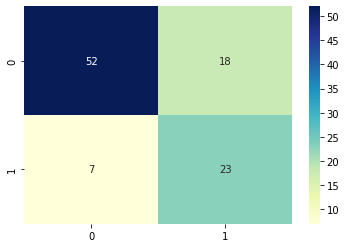

In [5]:
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.3)   #0.6431
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.35)    #0.6444  -> 0.6479 지만 과적합이라고 봐도 무방
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.4)   #0.6342

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)


정확도: 0.7693
정밀도: 0.6133
재현율: 0.7887
AUC: 0.7743
F1: 0.6900


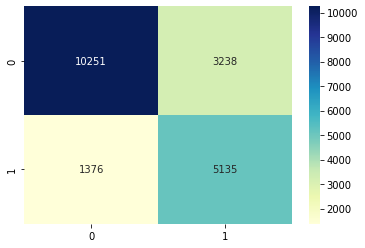

In [7]:
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.3)   #0.6431
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.35)    #0.6444  
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.4)   #0.6342

In [10]:
# 최적화 한걸로 ensemble 진행 // weight 제거
X = df.drop('depvar', axis=1)
y = df['depvar']
df
# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
rnd_clf = RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=8, n_estimators=150, random_state=42)
lgbm_clf = LGBMClassifier(max_depth=11, n_estimators=150, random_state=42)
xgb_clf = xgboost.XGBClassifier(max_depth=7, n_estimators=200, eval_metric='logloss', random_state=42) # 최적값 구한것

stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rnd',
                                RandomForestClassifier(max_depth=12,
                                                       min_samples_leaf=8,
                                                       min_samples_split=8,
                                                       n_estimators=150,
                                                       random_state=42)),
                               ('lgbm',
                                LGBMClassifier(max_depth=11, n_estimators=150,
                                               random_state=42)),
                               ('xgb',
                                XGBClassifier(eval_metric='logloss',
                                              max_depth=7, n_estimators=200,
                                              random_state=42))],
                   final_estimator=LGBMClassifier())


정확도: 0.7255
정밀도: 0.5567
재현율: 0.7670
AUC: 0.7362
F1: 0.6452


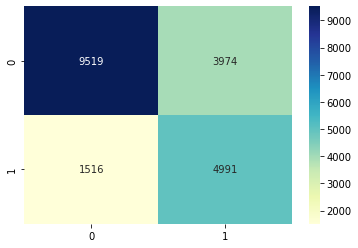

In [16]:
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.3)   #0.6431
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.32)    #0.6444  -> 가중치 제거 -> 0.6452
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.4)   #0.6342

In [17]:
df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')
df_test.head()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,ID
0,0.1449,16380.0,26.08,0,0,1,3486,10,0,0,0,9214,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8100,8100.0,0.00,1,4,278.78,0.311,0.0,0.0,460.40,700,704,0
1,0.1899,65000.0,13.97,0,0,0,25305,20,0,0,0,115612,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,20000,20000.0,0.00,0,10,518.71,0.885,0.0,0.0,4866.68,675,679,1
2,0.1049,53000.0,23.28,0,0,0,10910,21,0,0,0,33017,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,10000,10000.0,16.25,1,7,324.98,0.580,0.0,0.0,1451.06,675,679,2
3,0.1757,71800.0,30.32,0,0,0,42423,26,0,0,0,152515,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,27200,27200.0,0.00,0,16,684.36,0.701,0.0,0.0,7068.11,665,669,3
4,0.2020,50000.0,25.61,0,2,0,21703,24,0,0,0,135282,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,22000,22000.0,0.00,0,13,585.32,0.622,0.0,0.0,7754.20,710,714,4


## 제출

In [18]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/competition_1st/sample_submission.csv')

# prediction 수행
df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')
submit['answer'] = stacking_clf.predict_proba(df_test.drop(columns=['ID']))[:,1]>0.35
change = {True:1, False:0}
submit.answer = submit.answer.map(change)
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/competition_1st/submission_8.csv', index=False)

In [ ]:
submit.head()

,ID,answer
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


# Single Model(XGBoost)
## XGBClassifier의 하이퍼 파라미터 설명
- **LINK** : https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
- **max_depth=3** : 디시전 트리의 최대 깊이
- **learning_rate=0.1** : 0과 1 사이의 값을 가지는 부스팅에 대한 학습률(eta). 매 부스팅 단계 이후 새로이 추가된 가중치는 이 파라미터로 조정된다. 이 값이 낮을수록 보수적이며, 수렴에 필요한 더 많은 디시전 트리가 필요하다.
- **n_estimators=100** : 라운드의 횟수 또는 부스팅된 디시전 트리의 개수
- **silent=True** : 부스팅의 수행 동안 메시지를 출력할지에 대한 여부
- **objective="reg:linear"** : 모델이 학습할 작업의 분류, 미리 정의된 작업은 문자열로 지정이 가능하지만, 그렇지 않은 경우 콜러블callable을 만들어서 지정할 수도 있다.
- **booster="gbtree"** : 'gbtree', 'gblinear', 'dart'일 수 있다. 'dart'는 드롭아웃(dropout)이라는 특성을 추가한다(과적합 방지를 위해 무작위로 디시전 트리를 선택해 제거(드롭)한다). 'gblinear'는 정규화된 선형 모델을 만든다(디시전 트리가 아니라 라소 회귀와 유사하다).
- **nthread=None** : 더 이상 사용되지 않는다.
- **n_jobs** : 사용할 스레드의 개수
- **gamma=0** : 노드 분할에 필요한 최소 손실 감소
- **min_child_weight=1** : 자식 노드 생성에 필요한 헤시안(hessian) 합의 최솟값
- **max_delta_step=0** : 보다 보수적으로 갱신을 수행하도록 만드는 값. 불균형 범주의 데이터셋에 대해서는 1부터 10까지의 값으로 설정한다.
- **subsample=1** : 부스팅에 사용할 샘플의 비율
- **colsample_bytree=1** : 부스팅에 사용할 특징 열의 비율
- **colsample_bylevel=1** : 각 디시전 트리의 수준별 사용할 특징 열의 비율
- **colsample_bynode=1** : 각 디시전 트리의 노드별 사용할 특징 열의 비율
- **reg_alpha=0** : L1 정규화(가중치의 평균). 이 값이 클수록 보수적이게 된다.
- **reg_lambda=1** : L2 정규화(가중치의 제곱근). 이 값이 클수록 보수적이게 된다.
- **base_score=.5** : 초기 편향치(bias)
- **seed=None** : 더 이상 사용되지 않는다.
- **random_state=0** : 난수 생성 시드
- **missing=None** : 누락된 데이터가 해석될 값. None은 np.nan을 의미한다.
- **importance_type='gain'** : 특징 중요도의 유형. 'gain', 'weight', 'cover', 'total_gain', 'total_cover'로 설정될 수 있다.

In [ ]:
# 하이퍼 파라미터 튜닝
xgb_clf = xgboost.XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
# GPU사용시ㅡ tree_method='gpu_hist' 
# Do not use this for test/validation tasks as some information may be lost in quantisation. 
# This DMatrix is primarily designed to save memory in training from device memory inputs by avoiding intermediate storage. 

param_grid = {'max_depth':[11],
              'n_estimators':[100, 150, 200, 250],
              'early_stoppings' : 40}

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='accuracy', 
                           error_score=0) 

results=grid_search.fit(X_train, y_train)

results.best_params_

{'max_depth': 11, 'n_estimators': 100}

In [ ]:
# best parameter를 사용하여 prediction 수행
xgb_clf = xgboost.XGBClassifier(max_depth = results.best_params_['max_depth'],
                                n_estimators = results.best_params_['n_estimators'],
                                eval_metric='mlogloss')

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_valid)

In [ ]:
# y_valid가 0 또는 1일 확률 출력
y_pred_prob = xgb_clf.predict_proba(X_valid)

print(len(y_pred_prob))
y_pred_prob

20000


array([[0.9355947 , 0.0644053 ],
       [0.32453138, 0.6754686 ],
       [0.9188567 , 0.08114331],
       ...,
       [0.5913547 , 0.4086453 ],
       [0.7550378 , 0.2449622 ],
       [0.97016555, 0.02983447]], dtype=float32)

In [ ]:
# y_valid가 1일 확률 출력
y_pred_prob[:,1]

array([0.0644053 , 0.6754686 , 0.08114331, ..., 0.4086453 , 0.2449622 ,
       0.02983447], dtype=float32)

In [ ]:
# y_valid 예측값 출력
# y_pred_prob[:,1]이 0.5(threshold)보다 큰 경우 1의 예측값을 return한다

print(len(y_pred_xgb))
y_pred_xgb

20000


array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
# 1로 예측된 y_valid 갯수 및 비율 출력
print(y_pred_xgb.sum())
print(y_pred_xgb.sum()/len(y_pred_xgb))

5039
0.25195


In [ ]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    # sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')


정확도: 0.7492
정밀도: 0.6515
재현율: 0.5018
AUC: 0.6856
F1: 0.5669


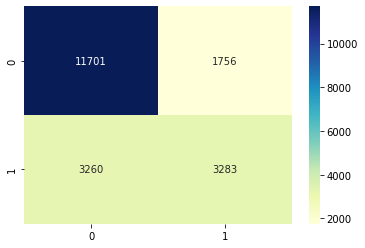

In [ ]:
# xgboost 성능 확인
get_clf_eval(y_valid, y_pred_xgb)


정확도: 0.7460
정밀도: 0.6073
재현율: 0.6330
AUC: 0.7170
F1: 0.6199


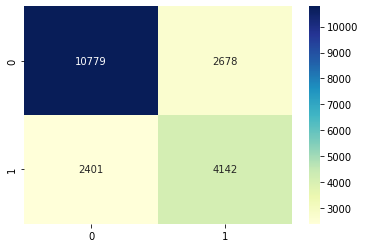

In [ ]:
# threshold 변경 및 성능 확인
# get_clf_eval(y_valid, y_pred_prob[:,1]>0.4)
get_clf_eval(y_valid, xgb_clf.predict_proba(X_valid)[:,1]>0.4)

# Ensemble(Voting)

In [ ]:
rnd_clf = RandomForestClassifier()
lgbm_clf = LGBMClassifier()
# rid_clf = RidgeClassifier()
# dtc_clf = DecisionTreeClassifier()
# svm_clf = SVC()
# ada_clf = AdaBoostClassifier()
# gbc_clf = GradientBoostingClassifier()
# bag_clf = BaggingClassifier()
# ext_clf = ExtraTreesClassifier()
# knn_clf = KNeighborsClassifier()
# svc_clf = SVC()

voting_clf = VotingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], voting='soft')


정확도: 0.7459
정밀도: 0.6090
재현율: 0.6237
AUC: 0.7145
F1: 0.6163


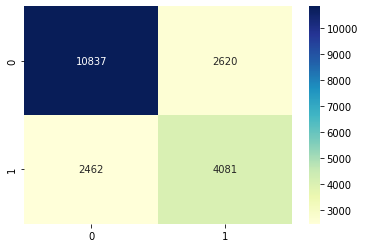

In [ ]:
for clf in (rnd_clf, lgbm_clf, xgb_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred_vote = clf.predict_proba(X_valid)[:,1]>0.4 # threshold 변경

# ensemble(voting) 성능 확인
get_clf_eval(y_valid, y_pred_vote)

# Ensemble(Stacking)


정확도: 0.7519
정밀도: 0.6574
재현율: 0.5045
AUC: 0.6883
F1: 0.5709


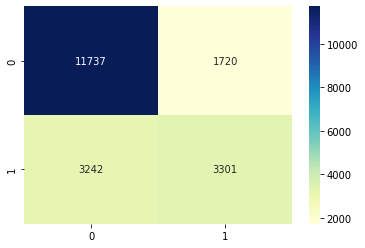

In [ ]:
stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)

# Submission

In [ ]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/competition_1st/sample_submission.csv')

# prediction 수행
df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')
submit['answer'] = stacking_clf.predict_proba(df_test.drop(columns=['ID']))[:,1]>0.35
change = {True:1, False:0}
submit.answer = submit.answer.map(change)
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/competition_1st/prediction4.csv', index=False)

In [ ]:
submit.head()

,ID,answer
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
